In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/My Drive/MDS0_K278_NguyenYenQuynhDan'

/content/gdrive/My Drive/MDS0_K278_NguyenYenQuynhDan


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [5]:
img_width, img_height = 224, 224
train_data_dir = 'dataset/train'
validation_data_dir = 'dataset/test'

In [6]:
model = applications.VGG16(weights = 'imagenet',
                           include_top=False,
                           input_shape = (img_width, img_height, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [7]:
for layer in model.layers:
  layer.trainable = True

In [8]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

In [9]:
model_final = Model(inputs = model.input, outputs= predictions)

In [10]:
model_final.compile(loss = 'categorical_crossentropy',
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9),
                    metrics=['accuracy'])

In [11]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range=0.3,
                                   rotation_range=30)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height, 
                                                                   img_width),
                                                    batch_size = 32, 
                                                    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                    target_size = (img_height, 
                                                                   img_width),
                                                    class_mode = "categorical")

Found 8048 images belonging to 2 classes.
Found 1637 images belonging to 2 classes.


In [14]:
checkpoint = ModelCheckpoint("PreTrained/vgg16_check_point.h5", 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq=1)
early = EarlyStopping(monitor='val_loss', 
                      min_delta=0.001, 
                      patience=20, 
                      verbose=1, 
                      mode='auto')

In [15]:
import datetime
t0 = datetime.datetime.now()
print(t0)

2022-09-06 06:57:38.309826


In [16]:
history = model_final.fit(train_generator, 
                          epochs=100,
                          validation_data = validation_generator,
                          verbose = 1,
                          callbacks = [checkpoint, early])

Output hidden; open in https://colab.research.google.com to view.

In [17]:
t1 = datetime.datetime.now()
print(t1-t0)

3:39:04.657896


In [18]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
46,0.013868,0.996024,0.018300,0.995724
47,0.011735,0.996024,0.017025,0.993280
48,0.011876,0.996645,0.027183,0.991448
49,0.012337,0.995775,0.012995,0.995724
50,0.016296,0.993663,0.016092,0.995113


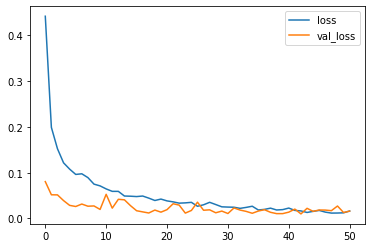

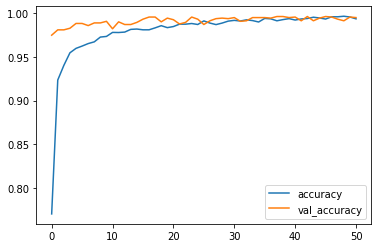

In [19]:
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

In [20]:
#save model
from tensorflow.keras.models import load_model
model_final.save('PreTrained/vgg16_model.h5')
print('save!!!')

save!!!


Nhận xét: 
- Mô hình pretrained train lâu hơn so với mô hình CNN gốc khoảng 3 tiếng nhưng mà accuracy cao hơn rất là nhiều, đến hơn 99.5% (kể cả val_accuracy)
- Độ nhiễu cũng giảm thiểu rất tốt, cả loss lẫn val_loss đều được cải thiện rõ rệt

In [21]:
#Making new predictions
from tensorflow.keras.models import load_model
classifier = load_model('PreTrained/vgg16_model.h5')

import numpy as np
from tensorflow.keras.preprocessing import image

In [22]:
def result(test_image):
    test_image = image.img_to_array(test_image)
    #print(test_image.shape)
    test_image = test_image/255
    test_image = np.expand_dims(test_image, axis = 0)
    #print(test_image.shape)

    result = classifier.predict(test_image)
    #print(result)
    
    # 0: fish, 1: plastic waste; sigmoid có ngưỡng 0.5
    if result[0][0] > result[0][1]:
        prediction = 'Fish'
    else:
        prediction = 'PlasticWaste'
    return prediction

In [23]:
classifier.load_weights('PreTrained/vgg16_model.h5')
test_evaluation= classifier.evaluate(validation_generator)
print('Test Accuracy:', round(test_evaluation[1], 4), 
        '; Test loss:', round(test_evaluation[0], 4))

52/52 [==============================] - 15s 279ms/step - loss: 0.0161 - accuracy: 0.9951
Test Accuracy: 0.9951 ; Test loss: 0.0161


In [24]:
import os 
predict_path= r'/content/gdrive/My Drive/MDS0_K278_NguyenYenQuynhDan/dataset/single_prediction/'
list_image= os.listdir(predict_path)

In [25]:
df= pd.DataFrame(columns=['name_file', 'truth', 'predict'])
name_file=[]
truth=[]
predict=[]

In [26]:
for i in range(len(list_image)):
    path= predict_path + list_image[i]
    test_img= image.load_img(path, target_size=[224, 224])
    name_file.append(list_image[i])
    truth.append(list_image[i].split('_')[0])
    predict.append(result(test_img))

df['name_file']= name_file
df['truth']= truth
df['predict']= predict
df.to_csv('PreTrained/prediction_VGG16.csv')

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
confusion_matrix(df['truth'], df['predict'])

array([[50,  0],
       [ 4, 46]])

In [28]:
print(classification_report(df['truth'], df['predict']))

              precision    recall  f1-score   support

        Fish       0.93      1.00      0.96        50
PlasticWaste       1.00      0.92      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

